# Support vector machines
## Data Science Community of Practice
### Aaron Hopkinson

* Code examples adapted from the [Python Data Science Handbook](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.07-Support-Vector-Machines.ipynb) (by Jake VanderPlas)
* Original code released under an [MIT license](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/LICENSE-CODE)

In [1]:
from IPython.display import HTML

# Method for hiding code taken from Stack Overflow:
# https://stackoverflow.com/a/28073228
def toggle_code():
    return HTML('''
    <script>
      code_show=true;
      function code_toggle() {
        if (code_show) {
          $('div.input').hide();
        } else {
          $('div.input').show();
        }
        code_show = !code_show;
      }
      $(document).ready(code_toggle);
    </script>
    <strong>If no code is displayed, press this button:</strong>
    <form action="javascript:code_toggle()">
      <input type="submit" value="Toggle code on/off">
    </form>
    ''')
toggle_code()

# Introduction

* When many people think of ML, they think of neural networks
  * Complex models - very powerful, but can also make it relatively easy to overfit
* Many ML methods may have a large number of hyperparameters which need tuning
* Don't always need a complicated model - should use the simplest model we can
* Focus on a relatively simple supervised ML method with fewer hyperparameters...

# Support vector machines

* Developed in the 1990s by Vapnik et al
* Supervised learning model (requires labels/truth)
* Original formulation (SVMs) designed for (non-probabilistic) linear binary classification
* Later extended to non-linear classification and regression
  * Can handle multi-class problems as set of one-vs-rest or one-vs-one binary classifiers
* Available in `scikit-learn` (in the scientific software stack)

# More on SVMs

* Based on convex optimization => unique optimal solution
* Produces compact models (depending only on the support vectors)
* Fast at prediction
* Works well for high dimensional datasets
* Scales as $\mathcal{O}(N^2)$ (best case) or $\mathcal{O}(N^3)$ (worst case)

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

Suppose we have a 2D dataset with two possible classes (red and yellow)

* We can define a discriminative binary classifier by drawing a line between the two classes
* SVMs are based around the concept of defining a **separating hyperplane**

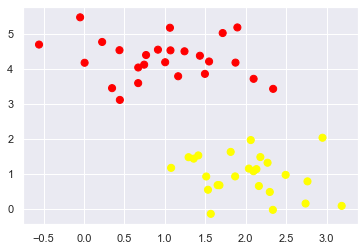

In [3]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

A problem: how do we choose the best possible line?

* 3 possible lines - which is the best one?
* What about when a new data point (red 'x') is added?

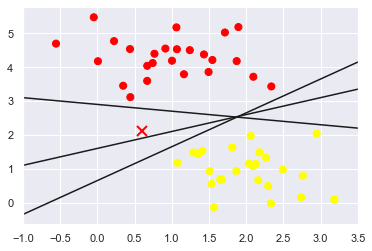

In [4]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

* When considering a new point, we are concerned with the **generalization error**
* SVMs choose separating hyperplane by **maximising the margin**
* The classifier with the largest margin will be the one that has the lowest generalization error
* i.e: choose the hyperplane such that the distance from the hyperplane to the nearest point on each side (the margin) is maximised

Below, the same three hyperplanes with their margins also displayed:

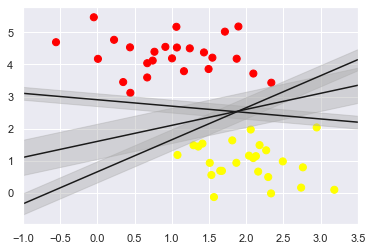

In [5]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

In [6]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   marker='o', edgecolors='black',
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

Fitting a support vector machine in `scikit-learn` is relatively straightforward:

```
from sklearn.svm import SVC

model = SVC(kernel='linear', C=1e10)
model.fit(X, y)
```

With SVMs, we have two main hyperparameters, the kernel and `C`, a regularization parameter

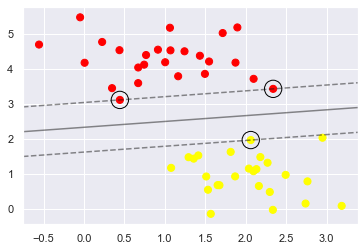

In [7]:
from sklearn.svm import SVC

# SVC stands for "support vector classifier"
model = SVC(kernel='linear', C=1e10)
model.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

* The highlighted points are the **support vectors** - data points which lie along the margin
* Indicated by the name, these are important: these are the points which define the classifier
* If a point is on the correct side of the margin, it doesn't modify the fit if it is further away than the support vector
* In `scikit-learn`, once we've fitted our model, we can access these through
`model.support_vectors_`

In [8]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

In [9]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1e10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

We see the effect of adding more points (from the same dataset)
* None of the new points lie closer to the margin than the original support vectors so the model is unchanged

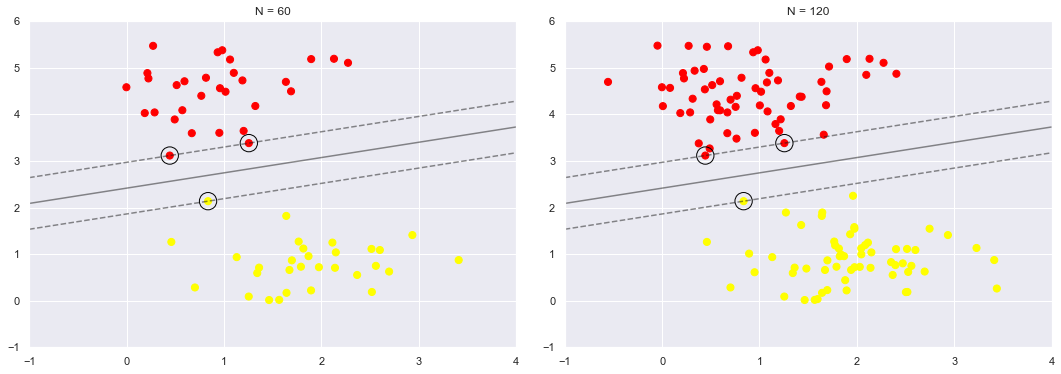

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

In [11]:
from ipywidgets import interact, fixed
interact(plot_svm, N=[10, 200], ax=fixed(None));

interactive(children=(Dropdown(description='N', options=(10, 200), value=10), Output()), _dom_classes=('widget…

# Softening the margins

* In the previous examples the two classes were well separated
* It was relatively straightforward to visualize how maximizing the margin could define an optimal separating hyperplane
* What about when things are a little more messy?

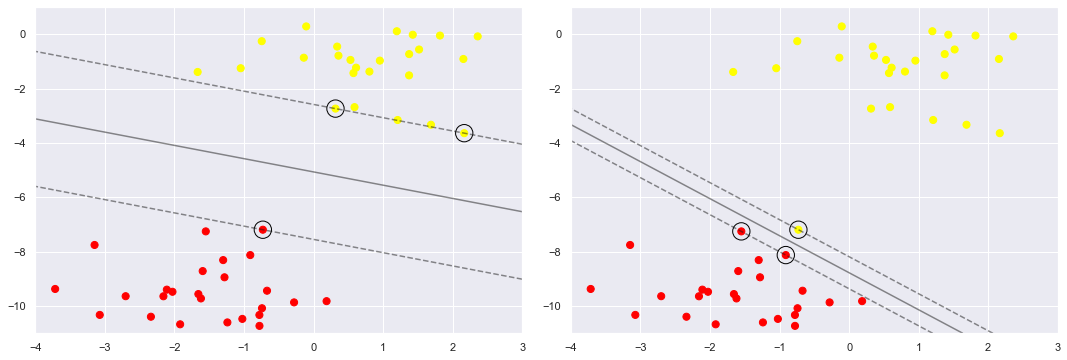

In [12]:
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=2, cluster_std=1.0)
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

# original plot
ax1.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
ax1.set_xlim(-4, 3)
ax1.set_ylim(-11, 1)
model = SVC(kernel='linear', C=1e10)
model.fit(X, y)
plot_svc_decision_function(model, ax1)

# now change the label of one of the support vectors
# find index
idx = np.where(X == model.support_vectors_[0])[0][0]
# change label
y[idx] = 1
ax2.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
ax2.set_xlim(-4, 3)
ax2.set_ylim(-11, 1)
model = SVC(kernel='linear', C=1e10)
model.fit(X, y)
plot_svc_decision_function(model, ax2)

* By misclassifying only one point, we were able to signficantly change the decision boundary
* This is an artificial example, but it should be clear that *hard margins* can lead to significant changes in the decision boundary

* Real world data is not likely to be quite so well separated, and defining the boundary can be more challenging...
* In order to create a model that generalizes well, we might need to allow for some small amount of misclassification

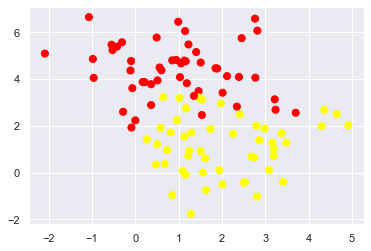

In [13]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

* This amount of allowable misclassification is controlled by the parameter `C`
* High values of `C` result in hard margins (fewer misclassified points)
* Lower values of `C` result in soft margins
* This is a form of **regularization** and makes the model less sensitive to misclassified points resulting in models which generalize better
* Does so by adjusting the tradeoff between the number of misclassified points and the width of the margin

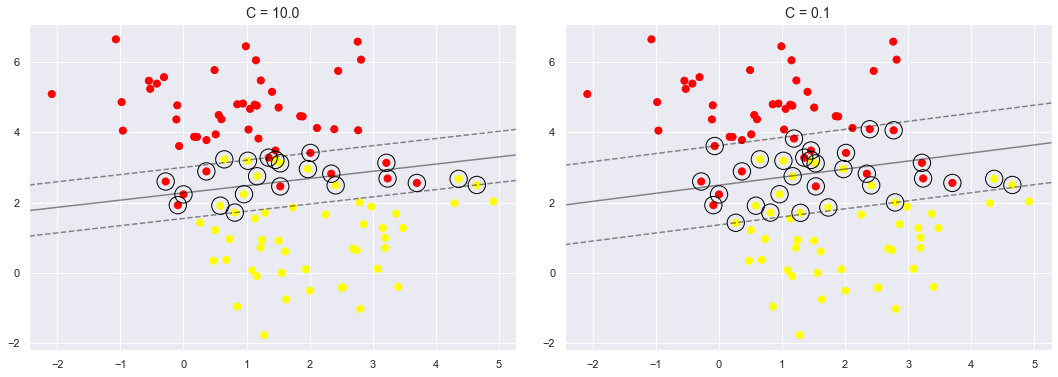

In [14]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

# How do I choose C?

* Depends on the dataset
* General approach with ML techniques:
  - Split data into train, validation and test sets
  - Hyperparameter tuning on train + validation sets to select best model
  - Final model performance measured on test set (not validation set)
* Best to use (K-fold) cross validation for better estimates of performance
* For iterating over possible parameters, Grid Search is an exhastive search mechanism.
* `GridSearchCV` is one option in `scikit-learn`
* For more details, see [Python Data Science Handbook](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.03-Hyperparameters-and-Model-Validation.ipynb) 

# Kernel SVM

* So far we have worked on the assumption that the data is linearly seperable
* What if this is not the case? e.g:

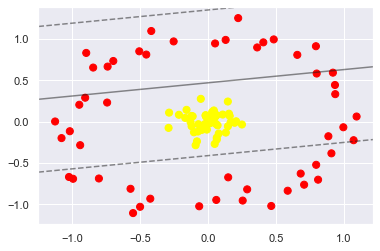

In [15]:
from sklearn.datasets import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

# Kernel trick

* Make use of the [kernel trick](https://en.wikipedia.org/wiki/Kernel_method#Mathematics:_the_kernel_trick) to define non-linear hyperplanes
* Kernel trick:
  * Project data to higher dimensional space
  * Data is linearly separable in higher dimensional space
  * Don't actually need to do this projection - can make use of implicit embedding
* Appears in other ML techniques (e.g: Kernel PCA)

In [16]:
r = np.exp(-(X ** 2).sum(1))

In [17]:
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=(-90, 90), azim=(-180, 180),
         X=fixed(X), y=fixed(y));

interactive(children=(IntSlider(value=30, description='elev', max=90, min=-90), IntSlider(value=30, descriptio…

# Demonstration

Explicit embedding using:
    `r = np.exp(-(X ** 2).sum(1))`
    
We see that the data are now linearly separable in 3D

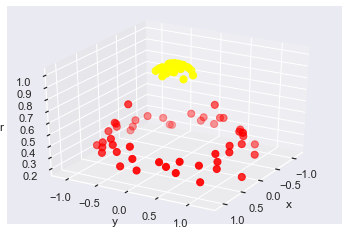

In [18]:
plot_3D(elev=30, azim=30, X=X, y=y)

# Training kernel SVM

* A number of different kernels available in `scikit-learn`
  * `linear`, `poly`, `rbf`, `sigmoid`
* RBF is probably the most common (radial basis function):
$$\exp{(-\gamma||x-x'||^2)}$$
* Introduces an extra hyper-parameter: $\gamma$ (>0)
* To use:
```
clf = SVC(kernel='rbf', C=1e6, gamma='scale')
clf.fit(X, y)
```
* In sklearn, `gamma='scale'` is `1/(n_features * X.var())`

In [19]:
clf = SVC(kernel='rbf', C=1e6)
clf.fit(X, y)

SVC(C=1000000.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

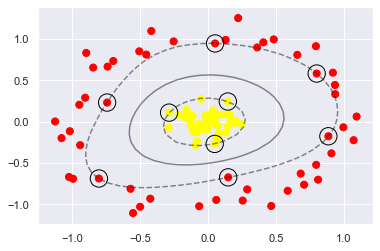

In [20]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

# Example: Classifying faces

* Using the "Labelled Faces in the Wild" dataset (downloadable from within scikit-learn)
* 13,233 photos of public figures, 5749 classes
* Each image is 62 x 47 pixels (2914 dimensional)
* (By default downloads to `~/scikit_learn_data`)

In [21]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


In [22]:
toggle_code()

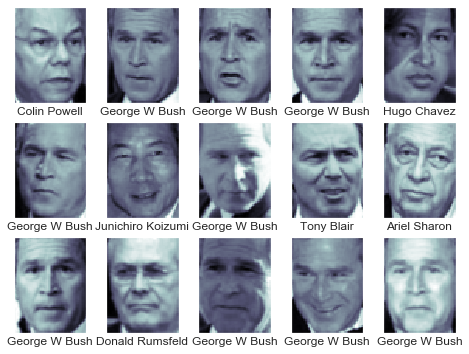

In [23]:
fig, ax = plt.subplots(3, 5, figsize=(8,6))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

In [24]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=42)

In [25]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

pca = PCA(n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: user 1min 37s, sys: 7.17 s, total: 1min 44s
Wall time: 37.5 s
{'svc__C': 10, 'svc__gamma': 0.001}


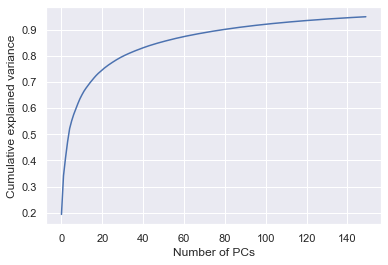

In [26]:
plt.plot(grid.best_estimator_['pca'].explained_variance_ratio_.cumsum());
plt.xlabel('Number of PCs');
plt.ylabel('Cumulative explained variance');

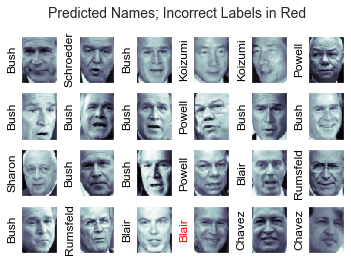

In [27]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

In [28]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.73      0.69        15
     Colin Powell       0.80      0.87      0.83        68
  Donald Rumsfeld       0.74      0.84      0.79        31
    George W Bush       0.92      0.83      0.88       126
Gerhard Schroeder       0.86      0.83      0.84        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.92      1.00      0.96        12
       Tony Blair       0.85      0.95      0.90        42

         accuracy                           0.85       337
        macro avg       0.83      0.84      0.84       337
     weighted avg       0.86      0.85      0.85       337



<div><img src="https://upload.wikimedia.org/wikipedia/commons/2/26/Precisionrecall.svg" width="30%"/></div>
Image taken from https://en.wikipedia.org/wiki/F1_score

* F1-score is the harmonic mean of precision and recall
* Support is the number of number of occurances of each class

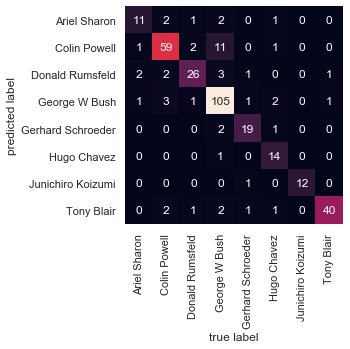

In [29]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

# Support vector regression

* We can also do regression with support vector machines
* In `scikit-learn` we can use `sklearn.svm.SVR`
* Operation is similar to `SVC`, except now we want to go through the points rather than separating them
* Have the `kernel` and `C` hyperparameters, but an additional one `epsilon`
    * Choose these in the same way

In [30]:
toggle_code()

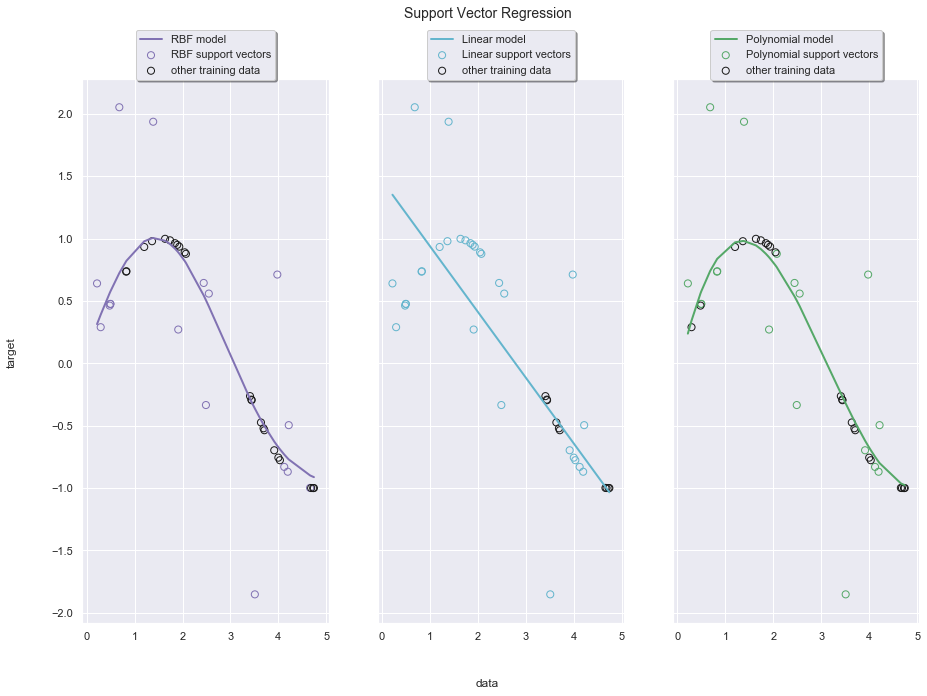

In [31]:
# Code taken from:
# https://scikit-learn.org/stable/auto_examples/svm/plot_svm_regression.html
from sklearn.svm import SVR

# Generate sample data
X = np.sort(5 * np.random.rand(40, 1), axis=0)
y = np.sin(X).ravel()

# Add noise to targets
y[::5] += 3 * (0.5 - np.random.rand(8))

# Fit regression models
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
svr_lin = SVR(kernel='linear', C=100, gamma='auto')
svr_poly = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1,
               coef0=1)

# Look at the results
lw = 2

svrs = [svr_rbf, svr_lin, svr_poly]
kernel_label = ['RBF', 'Linear', 'Polynomial']
model_color = ['m', 'c', 'g']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10), sharey=True)
for ix, svr in enumerate(svrs):
    axes[ix].plot(X, svr.fit(X, y).predict(X), color=model_color[ix], lw=lw,
                  label='{} model'.format(kernel_label[ix]))
    axes[ix].scatter(X[svr.support_], y[svr.support_], facecolor="none",
                     edgecolor=model_color[ix], s=50,
                     label='{} support vectors'.format(kernel_label[ix]))
    axes[ix].scatter(X[np.setdiff1d(np.arange(len(X)), svr.support_)],
                     y[np.setdiff1d(np.arange(len(X)), svr.support_)],
                     facecolor="none", edgecolor="k", s=50,
                     label='other training data')
    axes[ix].legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
                    ncol=1, fancybox=True, shadow=True)

fig.text(0.5, 0.04, 'data', ha='center', va='center')
fig.text(0.06, 0.5, 'target', ha='center', va='center', rotation='vertical')
fig.suptitle("Support Vector Regression", fontsize=14)
plt.show()

# Conclusions

* SVMs are powerful techniques for supervised machine learning
* Originally designed for classification, but since extended to regression
* Relatively straightforward to fit with a minimal number of hyperparameters
* Through the kernel trick we are able to do non-linear fitting